In [112]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.sparse import hstack

from tqdm import tqdm

from collections import Counter
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

from xgboost import XGBClassifier


from sentence_transformers import SentenceTransformer

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
import transformers

from transformers import BertForSequenceClassification

from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
# Download NLTK stopwords if you haven't already

nltk.download('stopwords')
nltk.download('wordnet')

In [113]:
data = pd.read_csv('ai-ga-dataset-sampled.csv')
data.head(n = 8)

,doc_id,title,abstract,label
0,0,Exaggerated Autophagy in Stanford Type A Aorti...,\n\nThis study presents a novel transcriptome ...,1
1,1,ABO blood types and sepsis mortality,\n\nThe ABO blood types have been associated w...,1
2,2,AAV8-Mediated Angiotensin-Converting Enzyme 2 ...,\n\nTitle: AAV8-Mediated Angiotensin-Convertin...,1
3,3,MyCare study: protocol for a controlled trial ...,INTRODUCTION: People with serious mental illne...,0
4,4,Exploring collective emotion transmission in f...,Collective emotion is the synchronous converge...,0
5,5,Charaterization of H9 subtype influenza viruse...,\n\nThis study examines the charaterization of...,1
6,6,Multiple arterial conduits for multi-vessel co...,BACKGROUND: Advantages of multiple arterial co...,0
7,7,Non-invasive estimation of cerebral perfusion ...,OBJECTIVE: To identify if cerebral perfusion p...,0


In [114]:
train_data, test_data = train_test_split(data, test_size = 0.2, random_state = 42)

In [115]:
train_data.to_csv('train.csv', index = False)
test_data.to_csv('test.csv', index = False)

In [116]:
df = pd.read_csv('train.csv')


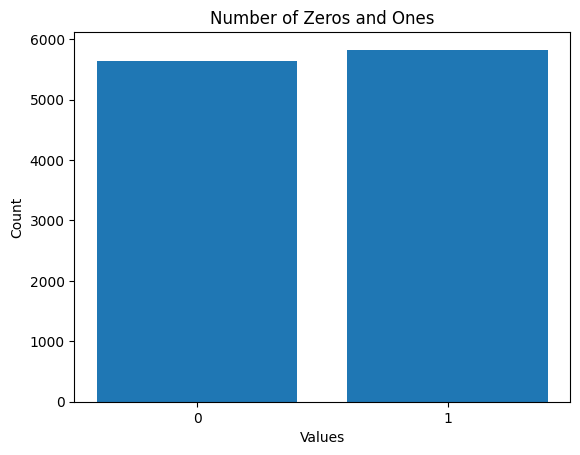

In [117]:
value_counts = df['label'].value_counts()

plt.bar(value_counts.index, value_counts.values)
plt.xticks([0, 1])
plt.xlabel('Values')
plt.ylabel('Count')
plt.title('Number of Zeros and Ones')
plt.show()

# Simple Approach: Using TF-IDF Vectorizer

In [118]:

def clean_text(text):
    
    text = text.lower()

    # Removing punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Removing newlines and tabs
    text = re.sub(r'\s+', ' ', text).strip()

    # removing stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)

    # lemmatizing words
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())

    return text

df['cleaned_abstract'] = df['abstract'].apply(clean_text)
df['cleaned_title'] = df['title'].apply(clean_text)


In [119]:
abstract_documents = df['cleaned_abstract'].values

abstract_tfidf_vectorizer = TfidfVectorizer(max_features = 1000, ngram_range = (1,2))

abstract_tfidf_matrix = abstract_tfidf_vectorizer.fit_transform(abstract_documents)

In [120]:
title_documents = df['cleaned_title'].values

title_tfidf_vectorizer = TfidfVectorizer(max_features = 250)

title_tfidf_matrix = title_tfidf_vectorizer.fit_transform(title_documents)

In [121]:
combined_tfidf_matrix = hstack([abstract_tfidf_matrix, title_tfidf_matrix])


In [122]:
X_train = combined_tfidf_matrix
y_train = df['label'].values


In [123]:
pca = PCA(n_components=100)

X_train_dense = X_train.todense()
X_train = pca.fit_transform(np.array(X_train_dense))

X_train.shape

(11464, 100)

In [124]:
# model = XGBClassifier()

# model.fit(X_train, y_train)

In [125]:
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [126]:
# Converting to PyTorch tensors
X_train_tensor = torch.tensor(X_train_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_val, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [127]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.hidden1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.hidden1(x)
        x = self.relu1(x)
        x = self.hidden2(x)
        x = self.relu2(x)
        x = self.output(x)
        return x

input_dim = 100 
hidden_dim = 50 
output_dim = 1 

net = SimpleNN(input_dim, hidden_dim, output_dim)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()  # Convert to float for division
    acc = correct.sum() / len(correct)
    return acc

num_epochs = 10 

for epoch in range(num_epochs):
    net.train()
    train_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    net.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = net(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item()
            val_acc += binary_accuracy(outputs, labels.unsqueeze(1))

    # Average losses and accuracy
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


100%|██████████| 287/287 [00:00<00:00, 763.91it/s]


Epoch 1/10, Train Loss: 0.4270, Val Loss: 0.1874, Val Acc: 0.9269


100%|██████████| 287/287 [00:00<00:00, 784.06it/s]


Epoch 2/10, Train Loss: 0.1873, Val Loss: 0.1743, Val Acc: 0.9308


100%|██████████| 287/287 [00:00<00:00, 773.09it/s]


Epoch 3/10, Train Loss: 0.1790, Val Loss: 0.1792, Val Acc: 0.9308


100%|██████████| 287/287 [00:00<00:00, 777.58it/s]


Epoch 4/10, Train Loss: 0.1740, Val Loss: 0.1739, Val Acc: 0.9323


100%|██████████| 287/287 [00:00<00:00, 783.20it/s]


Epoch 5/10, Train Loss: 0.1693, Val Loss: 0.1752, Val Acc: 0.9355


100%|██████████| 287/287 [00:00<00:00, 777.15it/s]


Epoch 6/10, Train Loss: 0.1633, Val Loss: 0.1671, Val Acc: 0.9364


100%|██████████| 287/287 [00:00<00:00, 780.31it/s]


Epoch 7/10, Train Loss: 0.1559, Val Loss: 0.1624, Val Acc: 0.9364


100%|██████████| 287/287 [00:00<00:00, 777.94it/s]


Epoch 8/10, Train Loss: 0.1500, Val Loss: 0.1587, Val Acc: 0.9403


100%|██████████| 287/287 [00:00<00:00, 783.72it/s]


Epoch 9/10, Train Loss: 0.1441, Val Loss: 0.1579, Val Acc: 0.9403


100%|██████████| 287/287 [00:00<00:00, 783.32it/s]

Epoch 10/10, Train Loss: 0.1380, Val Loss: 0.1591, Val Acc: 0.9377


#### Testing or Inference

In [128]:
test_df = pd.read_csv('test.csv')

test_df['cleaned_abstract'] = test_df['abstract'].apply(clean_text)
test_df['cleaned_title'] = test_df['title'].apply(clean_text)


In [129]:
test_abstract_tfidf = abstract_tfidf_vectorizer.transform(test_df['cleaned_abstract'].values)
test_title_tfidf = title_tfidf_vectorizer.transform(test_df['cleaned_title'].values)

test_combined_tfidf_matrix = hstack([test_abstract_tfidf, test_title_tfidf])


In [130]:
X_test = test_combined_tfidf_matrix
X_test_dense = X_test.todense()
X_test = pca.transform(np.array(X_test_dense))



In [131]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

test_dataset = TensorDataset(X_test_tensor)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) 

def predict(model, data_loader):
    model.eval()  
    predictions = []

    with torch.no_grad():
        for inputs in data_loader:
            inputs = inputs[0]  
            outputs = model(inputs)
            preds = torch.sigmoid(outputs).round()
            predictions.extend(preds.squeeze().tolist())

    return predictions

test_predictions = predict(net, test_loader)


In [133]:
print(classification_report(test_predictions, test_df['label']))

              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93      1481
         1.0       0.92      0.94      0.93      1386

    accuracy                           0.93      2867
   macro avg       0.93      0.93      0.93      2867
weighted avg       0.93      0.93      0.93      2867



##### Accuracy: 93%  and F1: 93%

# Another simpler Approach: Using Glove Embeddings

In [134]:

# Loading GloVe embeddings
embeddings_dict = {}
with open("glove.6B.100d.txt", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector


In [135]:
# Averaging words to get sentence embeddings

def document_vector(doc):
    words = doc.split()
    doc_vector = np.mean([embeddings_dict[word] for word in words if word in embeddings_dict], axis=0)
    return doc_vector


abstract_vectors = np.array([document_vector(doc) for doc in df['cleaned_abstract']])
title_vectors = np.array([document_vector(doc) for doc in df['cleaned_title']])

abstract_vectors, title_vectors = np.nan_to_num(abstract_vectors), np.nan_to_num(title_vectors)


In [136]:
combined_vectors = np.hstack((abstract_vectors, title_vectors))

X_train = combined_vectors
y_train = df['label'].values

X_train.shape

(11464, 200)

In [137]:
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_val, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)




In [139]:
input_dim = 200 
hidden_dim = 50 
output_dim = 1 

net = SimpleNN(input_dim, hidden_dim, output_dim)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()  # Convert to float for division
    acc = correct.sum() / len(correct)
    return acc

num_epochs = 20 

for epoch in range(num_epochs):
    net.train()
    train_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    net.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = net(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item()
            val_acc += binary_accuracy(outputs, labels.unsqueeze(1))

    # Average losses and accuracy
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

100%|██████████| 287/287 [00:00<00:00, 757.11it/s]


Epoch 1/20, Train Loss: 0.4798, Val Loss: 0.3637, Val Acc: 0.8377


100%|██████████| 287/287 [00:00<00:00, 769.59it/s]


Epoch 2/20, Train Loss: 0.3439, Val Loss: 0.3396, Val Acc: 0.8539


100%|██████████| 287/287 [00:00<00:00, 754.24it/s]


Epoch 3/20, Train Loss: 0.3092, Val Loss: 0.3248, Val Acc: 0.8578


100%|██████████| 287/287 [00:00<00:00, 749.21it/s]


Epoch 4/20, Train Loss: 0.2909, Val Loss: 0.3102, Val Acc: 0.8689


100%|██████████| 287/287 [00:00<00:00, 743.55it/s]


Epoch 5/20, Train Loss: 0.2801, Val Loss: 0.2993, Val Acc: 0.8752


100%|██████████| 287/287 [00:00<00:00, 751.87it/s]


Epoch 6/20, Train Loss: 0.2708, Val Loss: 0.2940, Val Acc: 0.8819


100%|██████████| 287/287 [00:00<00:00, 752.30it/s]


Epoch 7/20, Train Loss: 0.2549, Val Loss: 0.2960, Val Acc: 0.8754


100%|██████████| 287/287 [00:00<00:00, 750.15it/s]


Epoch 8/20, Train Loss: 0.2497, Val Loss: 0.3016, Val Acc: 0.8782


100%|██████████| 287/287 [00:00<00:00, 753.61it/s]


Epoch 9/20, Train Loss: 0.2421, Val Loss: 0.2913, Val Acc: 0.8824


100%|██████████| 287/287 [00:00<00:00, 749.23it/s]


Epoch 10/20, Train Loss: 0.2314, Val Loss: 0.2957, Val Acc: 0.8811


100%|██████████| 287/287 [00:00<00:00, 752.61it/s]


Epoch 11/20, Train Loss: 0.2242, Val Loss: 0.2961, Val Acc: 0.8798


100%|██████████| 287/287 [00:00<00:00, 753.74it/s]


Epoch 12/20, Train Loss: 0.2227, Val Loss: 0.2965, Val Acc: 0.8832


100%|██████████| 287/287 [00:00<00:00, 753.29it/s]


Epoch 13/20, Train Loss: 0.2098, Val Loss: 0.2921, Val Acc: 0.8830


100%|██████████| 287/287 [00:00<00:00, 754.14it/s]


Epoch 14/20, Train Loss: 0.2079, Val Loss: 0.3029, Val Acc: 0.8782


100%|██████████| 287/287 [00:00<00:00, 748.71it/s]


Epoch 15/20, Train Loss: 0.2004, Val Loss: 0.3014, Val Acc: 0.8804


100%|██████████| 287/287 [00:00<00:00, 753.93it/s]


Epoch 16/20, Train Loss: 0.1931, Val Loss: 0.3171, Val Acc: 0.8806


100%|██████████| 287/287 [00:00<00:00, 754.51it/s]


Epoch 17/20, Train Loss: 0.1877, Val Loss: 0.3172, Val Acc: 0.8774


100%|██████████| 287/287 [00:00<00:00, 753.67it/s]


Epoch 18/20, Train Loss: 0.1813, Val Loss: 0.3093, Val Acc: 0.8813


100%|██████████| 287/287 [00:00<00:00, 754.43it/s]


Epoch 19/20, Train Loss: 0.1782, Val Loss: 0.3114, Val Acc: 0.8815


100%|██████████| 287/287 [00:00<00:00, 751.80it/s]


Epoch 20/20, Train Loss: 0.1703, Val Loss: 0.3284, Val Acc: 0.8769


#### Testing or Inference

In [140]:
test_df = pd.read_csv('test.csv')

test_df['cleaned_abstract'] = test_df['abstract'].apply(clean_text)
test_df['cleaned_title'] = test_df['title'].apply(clean_text)

test_abstract_vectors = np.array([document_vector(doc) for doc in test_df['cleaned_abstract']])
test_title_vectors = np.array([document_vector(doc) for doc in test_df['cleaned_title']])

test_abstract_vectors, test_title_vectors = np.nan_to_num(test_abstract_vectors), np.nan_to_num(test_title_vectors)

test_combined_vectors = np.hstack((test_abstract_vectors, test_title_vectors))

X_test = test_combined_vectors
y_test = test_df['label'].values

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

test_dataset = TensorDataset(X_test_tensor)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) 

def predict(model, data_loader):
    model.eval()  
    predictions = []

    with torch.no_grad():
        for inputs in data_loader:
            inputs = inputs[0]  
            outputs = model(inputs)
            preds = torch.sigmoid(outputs).round()
            predictions.extend(preds.squeeze().tolist())

    return predictions

test_predictions = predict(net, test_loader)



In [141]:
print(classification_report(test_predictions, y_test))

              precision    recall  f1-score   support

         0.0       0.91      0.88      0.90      1501
         1.0       0.87      0.91      0.89      1366

    accuracy                           0.89      2867
   macro avg       0.89      0.89      0.89      2867
weighted avg       0.89      0.89      0.89      2867



##### Accuracy: 89%  and F1: 89%

##### Not so good approach. But increasing embedding size to 200 or 300 helps.

# Main Approach: Fine Tuning a pretrained BERT model from HuggingFace

In [61]:
train_text, val_text, train_labels, val_labels = train_test_split(df['abstract'], df['label'], test_size=0.1)

<Axes: xlabel='abstract', ylabel='Count'>

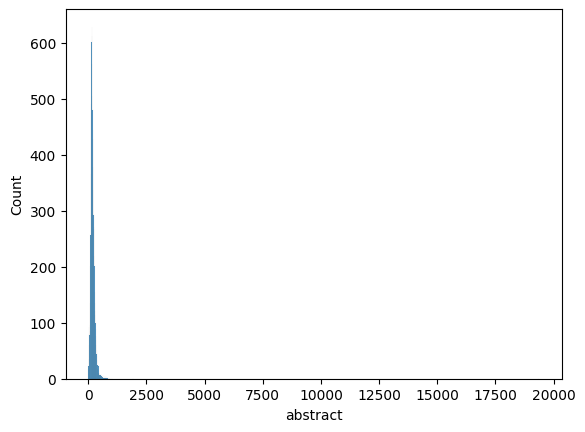

In [62]:
def get_num_words(text):
    
    words = re.findall(r'\b\w+\b', text)
    return len(words)

sns.histplot(train_text.apply(lambda x : get_num_words(x)))


In [63]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    padding='max_length',
    max_length=300,
    truncation=True
)


val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    padding='max_length',
    max_length=300,
    truncation=True
)

In [64]:
train_seq = torch.tensor(train['input_ids'])
train_mask = torch.tensor(train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(val['input_ids'])
val_mask = torch.tensor(val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

In [65]:
batch_size = 32

train_ds = TensorDataset(train_seq, train_mask, train_y)
train_dataloader =   DataLoader(train_ds, batch_size = batch_size, shuffle = False)


val_ds = TensorDataset(val_seq, val_mask, val_y)
val_dataloader =  DataLoader(val_ds, batch_size = batch_size, shuffle = False)

In [66]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

In [68]:
from tqdm import tqdm
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)
loss_function = nn.CrossEntropyLoss()

def train(model, dataloader):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, total=len(dataloader)):
        batch = [r.to(device) for r in batch]
        inputs, masks, labels = batch
        model.zero_grad()

        outputs = model(inputs, attention_mask=masks)
        logits = outputs.logits
        loss = loss_function(logits, labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    return total_loss / len(dataloader)
    
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in dataloader:
            batch = [r.to(device) for r in batch]
            inputs, masks, labels = batch

            outputs = model(inputs, attention_mask=masks)
            logits = outputs.logits
            loss = loss_function(logits, labels)
            total_loss += loss.item()

            predictions = torch.argmax(logits, dim=1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions
    average_loss = total_loss / len(dataloader)
    return average_loss, accuracy

epochs = 2

for epoch in range(epochs):
    train_loss = train(model, train_dataloader)
    val_loss, val_accuracy = evaluate(model, val_dataloader)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}')


100%|██████████| 323/323 [05:27<00:00,  1.01s/it]


Epoch 1, Train Loss: 0.07554053498328239, Val Loss: 0.004115138222308208, Val Accuracy: 1.0


100%|██████████| 323/323 [05:27<00:00,  1.01s/it]


Epoch 2, Train Loss: 0.009407833502764869, Val Loss: 0.008294308545171387, Val Accuracy: 0.995640802092415


In [69]:
MODEL_PATH = 'finetuned_model.pt'

torch.save(model.state_dict(), MODEL_PATH)

#### Testing or Inference

In [72]:
test_df = pd.read_csv('test.csv')

test_text = test_df.abstract
test_labels = test_df['label'].values

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    padding='max_length',
    max_length=300,
    truncation=True
)

test_seq = torch.tensor(test['input_ids'])
test_mask = torch.tensor(test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

test_ds = TensorDataset(test_seq, test_mask, test_y)

test_dataloader = DataLoader(test_ds, batch_size=32, shuffle=False)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [73]:
MODEL_PATH = 'finetuned_model.pt'

model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [75]:
def evaluate_model(model, dataloader):
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in dataloader:
            batch = [r.to(device) for r in batch]
            inputs, masks, labels = batch

            outputs = model(inputs, attention_mask=masks)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    accuracy = correct_predictions / total_predictions
    report = classification_report(all_labels, all_predictions, target_names=['AI Gen', 'Not'])  
    return accuracy, report

# Calculate test accuracy and classification report
test_accuracy, test_report = evaluate_model(model, test_dataloader)
print(f'Test Accuracy: {test_accuracy}')
print(test_report)


Test Accuracy: 0.9972096267875828
              precision    recall  f1-score   support

      AI Gen       0.99      1.00      1.00      1445
         Not       1.00      0.99      1.00      1422

    accuracy                           1.00      2867
   macro avg       1.00      1.00      1.00      2867
weighted avg       1.00      1.00      1.00      2867



##### Accuracy: 99-100%  and F1: 99-100%